In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MLFLOW = False

In [3]:
import pandas as pd
from pathlib import Path

def load_all_metrics_files(path):
    """
    Parcourt tous les sous-dossiers de `path`, charge les fichiers `df_metrics.csv`,
    et les combine en un seul DataFrame global.

    Parameters:
    - path (Path): Le chemin du dossier racine à parcourir.

    Returns:
    - pd.DataFrame: Le DataFrame global combinant tous les fichiers `df_metrics.csv`.
    """
    path = Path(path)
    all_metrics = []  # Liste pour stocker tous les DataFrames

    # Parcourir tous les sous-dossiers et rechercher les fichiers df_metrics.csv
    for file in path.rglob('df_metrics.csv'):
        try:
            # Charger le fichier CSV dans un DataFrame
            df = pd.read_csv(file)

            # Ajouter une colonne pour identifier la source du fichier
            df['source'] = str(file.parent)  # Ajouter le chemin du dossier parent

            # Ajouter le DataFrame à la liste
            all_metrics.append(df)
        except Exception as e:
            print(f"Erreur lors du chargement de {file}: {e}")

    # Combiner tous les DataFrames en un seul DataFrame global
    if all_metrics:
        df_global = pd.concat(all_metrics, ignore_index=True)
    else:
        df_global = pd.DataFrame()  # Si aucun fichier trouvé, retourne un DataFrame vide
 
    return df_global

if not MLFLOW:
    # Utilisation de la fonction
    path = Path('../GNN/firemen/firepoint/2x2/test/occurence_kmeans_thresh')
    df = load_all_metrics_files(path)

In [4]:
df

,Unnamed: 0,Run,apr_nbsinister_max_1,r2_nbsinister_max_1,KS_nbsinister_max_1,ks_1.0_nbsinister_max_1,ks_2.0_nbsinister_max_1,ks_3.0_nbsinister_max_1,ks_4.0_nbsinister_max_1,mae_raw_nbsinister_max_1,...,ks_5.0_saison_high_graph_3.0,ks_6.0_saison_high_graph_3.0,ks_8.0_saison_high_graph_3.0,ks_1.0_saison_medium_graph_3.0,ks_2.0_saison_medium_graph_3.0,ks_3.0_saison_medium_graph_3.0,ks_4.0_saison_medium_graph_3.0,ks_5.0_saison_medium_graph_3.0,ks_6.0_saison_medium_graph_3.0,ks_8.0_saison_medium_graph_3.0
0,0,departement-01-ain_xgboost_nbsinister_regressi...,0.48,0.107620,0.585093,0.497462,0.387097,0.297872,0.285714,0.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,departement-25-doubs_xgboost_nbsinister_regres...,0.41,0.218674,0.657292,0.479042,0.400000,NaN,0.285714,0.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,departement-78-yvelines_xgboost_nbsinister_reg...,0.65,0.359988,0.688030,0.632812,0.567164,0.482759,0.428571,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,departement-01-ain_xgboost_nbsinister_regressi...,0.52,0.174836,0.713671,0.539474,0.382022,0.352941,0.333333,0.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,departement-25-doubs_xgboost_nbsinister_regres...,0.32,-0.051441,0.775638,0.439024,0.285714,NaN,0.129032,0.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,departement-78-yvelines_xgboost_nbsinister_reg...,0.72,0.401598,0.805678,0.690909,0.581818,0.480000,0.461538,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,departement-01-ain_xgboost_nbsinister_regressi...,0.44,0.042459,0.445887,0.470149,0.380165,0.296296,0.266667,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,departement-25-doubs_xgboost_nbsinister_regres...,0.40,0.168808,0.471715,0.431250,0.411765,NaN,0.400000,0.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,departement-78-yvelines_xgboost_nbsinister_reg...,0.58,0.275499,0.454772,0.559783,0.500000,0.480000,0.428571,0.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,departement-01-ain_xgboost_nbsinister_regressi...,0.46,0.086236,0.536388,0.481752,0.384000,0.297872,0.285714,0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
if MLFLOW:
    metric = 'bad_prediction_modified_nbsinister_max_1'
    df = pd.read_csv(f'{metric}.csv')

    metric = 'wildfire_over_predicted_modified_nbsinister_max_1'
    df1 = pd.read_csv(f'{metric}.csv')

    metric = 'iou_modified_nbsinister_max_1'
    df2 = pd.read_csv(f'{metric}.csv')

    metric = 'apr_nbsinister_max_1'
    df3 = pd.read_csv(f'{metric}.csv')

    metric = 'r2_nbsninster_max_1'
    df4 = pd.read_csv(f'{metric}.csv')

    df = df.set_index('Run').join(df1.set_index('Run')['wildfire_over_predicted_modified_nbsinister_max_1']).reset_index()
    df = df.set_index('Run').join(df2.set_index('Run')['iou_modified_nbsinister_max_1']).reset_index()
    df = df3.set_index('Run').join(df2.set_index('Run')['apr_nbsinister_max_1']).reset_index()
    df = df4.set_index('Run').join(df2.set_index('Run')['r2_nbsninster_max_1']).reset_index()

    #df.dropna(subset=['temporal_spearman', 'temporal_mae', 'temporal_binary_f1', 'temporal_kendall'], inplace=True)
    df.drop_duplicates(inplace=True, keep='first')
    df.reset_index(drop=True, inplace=True)

In [6]:
def parse_run_name(x):
    dico = {}
    vec = x.split('_')
    dico['Department'] = vec[0]
    dico['Model'] = vec[1]
    i = 2
    if dico['Model']  == 'fwi':
        i += 1
        dico['Target'] = 'indice'
    else:
        dico['Target'] = vec[i]
        i += 1
    if dico['Model'] != 'fwi':
        dico['Task_type'] = vec[i]
        i += 1
        dico['loss'] = vec[i]
        i += 1
        if vec[i] == 'features':
            i += 1
    else:
        dico['loss'] = None
        dico['Task_type'] = 'Indice'

    dico['Number_of_samples'] = vec[i]
    i += 1
    dico['k_days'] = vec[i]
    i += 1
    dico['Number_of_features'] = vec[i]
    i += 1
    dico['Scale'] = vec[i]
    i += 1
    dico['Days_in_futur'] = vec[i]
    i += 1
    dico['Base'] = vec[i]
    i += 1
    dico['Method'] = vec[i]
    i += 1
    if vec[i] == 'kmeans':
        i += 1
        dico['kmeans_shift'] = vec[i]
        i += 1
        dico['kmeans_thresh'] = vec[i]
        i += 1
    dico['weight'] = vec[i]
    return dico

# Initialisation des colonnes avec des valeurs None
df['Department'] = None
df['Model'] = None
df['Target'] = None
df['Task_type'] = None
df['Loss_function'] = None
df['Number_of_samples'] = None
df['kdays'] = None
df['Number_of_features'] = None
df['Scale'] = None
df['Base'] = None
df['Method'] = None
df['Days_in_futur'] = None
df['weight'] = None
df['kmeans_thresh'] = None
df['kmeans_shift'] = None

# Boucle pour remplir les colonnes avec les valeurs de dico_parse
for index, row in df.iterrows():
    dico_parse = parse_run_name(row['Run'])
    
    # Mise à jour de chaque colonne avec les valeurs du dictionnaire dico_parse
    df.loc[index, 'Department'] = dico_parse.get('Department')
    df.loc[index, 'Model'] = dico_parse.get('Model')
    df.loc[index, 'Target'] = dico_parse.get('Target')
    df.loc[index, 'Task_type'] = dico_parse.get('Task_type')
    df.loc[index, 'Loss_function'] = dico_parse.get('loss')
    df.loc[index, 'Number_of_samples'] = dico_parse.get('Number_of_samples')
    df.loc[index, 'kdays'] = dico_parse.get('k_days')
    df.loc[index, 'Number_of_features'] = dico_parse.get('Number_of_features')
    df.loc[index, 'Scale'] = dico_parse.get('Scale')
    df.loc[index, 'Base'] = dico_parse.get('Base')
    df.loc[index, 'Method'] = dico_parse.get('Method')
    df.loc[index, 'Days_in_futur'] = dico_parse.get('Days_in_futur')

    df.loc[index, 'weight'] = dico_parse.get('weight')
    df.loc[index, 'kmeans_thresh'] = dico_parse.get('kmeans_thresh', 0)
    df.loc[index, 'kmeans_shift'] = dico_parse.get('kmeans_shift', 0)

/tmp/ipykernel_590701/764871983.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Department'] = None
/tmp/ipykernel_590701/764871983.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Model'] = None
/tmp/ipykernel_590701/764871983.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[

In [7]:
import seaborn as sns

def compare_models2(dff, depts, dept_markers, metrics, scale_to_analyse, col_to_analyse, dir_output, suffix):
    df = dff[dff['Scale'] == scale_to_analyse].copy(deep=True)
    task_types = df[col_to_analyse].unique()

    np.random.seed(42)  # Pour rendre le code reproductible (vous pouvez le changer ou le retirer)
    colors = sns.color_palette("husl", len(task_types))  # Palette de couleurs diversifiée et aléatoire

    #Associer chaque modèle à une couleur
    task_colors = dict(zip(task_types, colors))
    # Create a new figure for all departments
    fig, axs = plt.subplots(len(depts), len(metrics), figsize=(15, 3 * len(depts)), sharey='row')

    # Loop through each department
    for dept_index, dept in enumerate(depts):
        # Filtering the DataFrame for a specific department
        df_filtered = df[df['Department'].isin([dept])].reset_index()

        # Loop through each metric to create a subplot for each metric
        for metric_index, metric in enumerate(metrics):
            ax = axs[dept_index, metric_index] if len(depts) > 1 else axs[metric_index]
            for method in task_types:
                subset = df_filtered[df_filtered[col_to_analyse] == method]

                if len(subset) == 0:
                    continue

                subset = subset.sort_values(col_to_analyse)
                
                # Add label only for the first occurrence of each method
                label = method if dept_index == 0 else None  # Only show labels for the first department
                ax.plot(subset[col_to_analyse].values, subset[metric].values, marker=dept_markers[dept], linestyle='-', 
                        label=label, color=task_colors[method])  # Use task type color
                
            # Configuration for each subplot
            ax.set_ylim(0, 1)
            ax.set_xlabel(col_to_analyse)
            if dept_index == 0:  # Only set the title for the first row
                ax.set_title(f'{metric}', fontsize=12)
            #ax.set_xticks(subset[col_to_analyse].values, rotation=45)
            ax.grid(True)

        axs[dept_index, 0].set_ylabel('Metric Value')

    # Create a custom legend for task types and departments
    task_handles = [plt.Line2D([0], [0], color=task_colors[method], label=method) for method in task_types]
    dept_handles = [plt.Line2D([0], [0], marker=dept_markers[dept], linestyle='None', color='black', label=dept) for dept in depts]

    # Combine both legends
    fig.legend(handles=task_handles + dept_handles, loc='center left', bbox_to_anchor=(0.85, 0.85), title="Legend")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.savefig(dir_output / f'{col_to_analyse}_{suffix}.png')

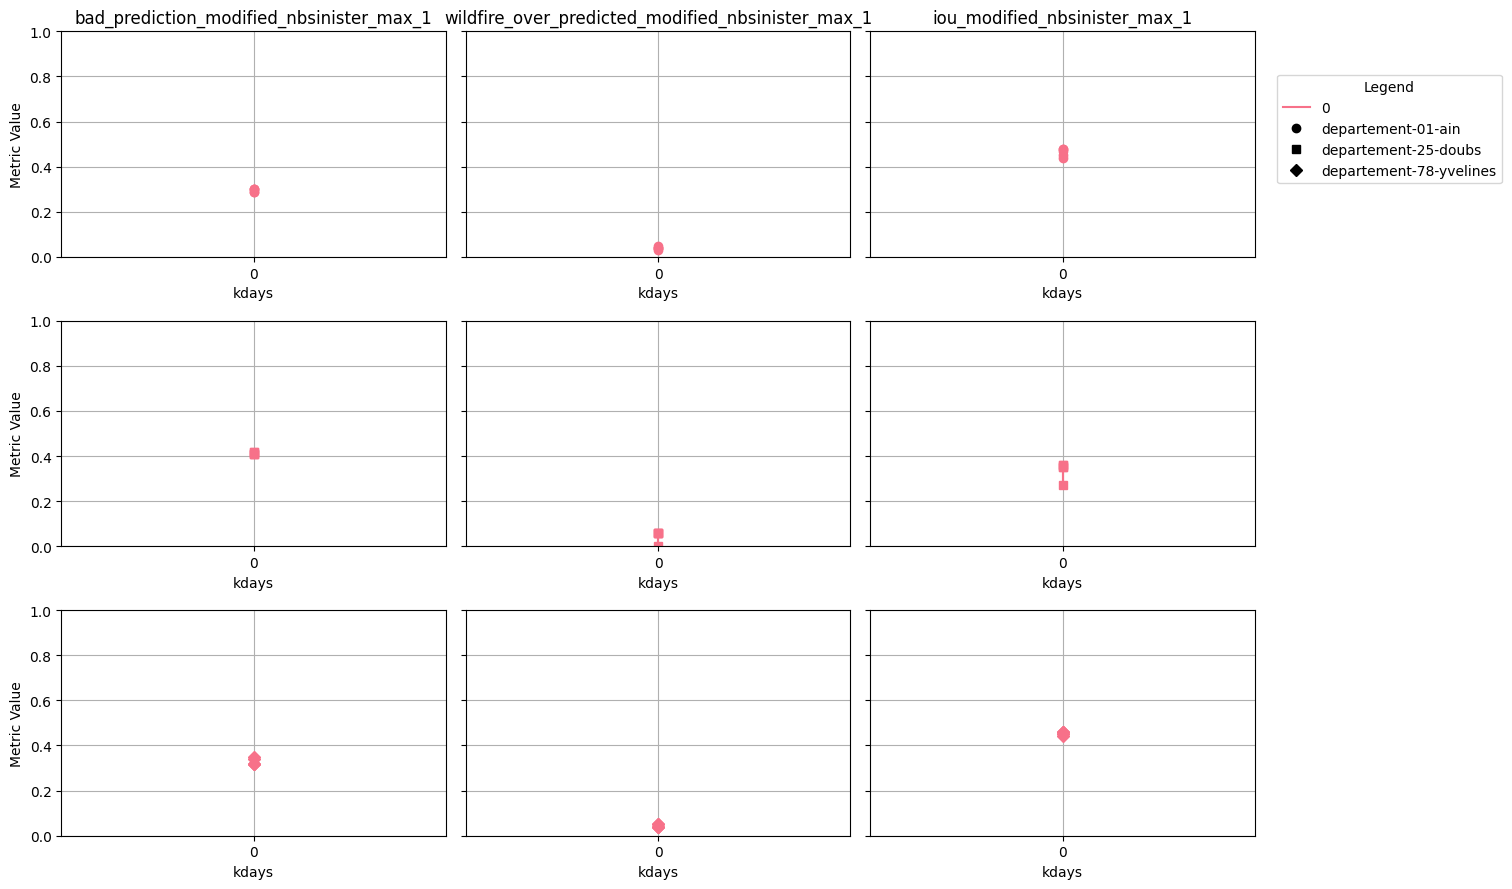

In [8]:
# Define markers for each department
dept_markers = {
    'departement-01-ain': 'o',   # Circle
    'departement-25-doubs': 's',   # Square
    'departement-78-yvelines': 'D',   # Diamond
    # Add more departments and their markers as needed
}
metrics =  ['bad_prediction_modified_nbsinister_max_1', 'wildfire_over_predicted_modified_nbsinister_max_1', 'iou_modified_nbsinister_max_1']

compare_models2(df, df.Department.unique(), dept_markers, metrics, 'departement', 'kdays', Path('./'), '1')

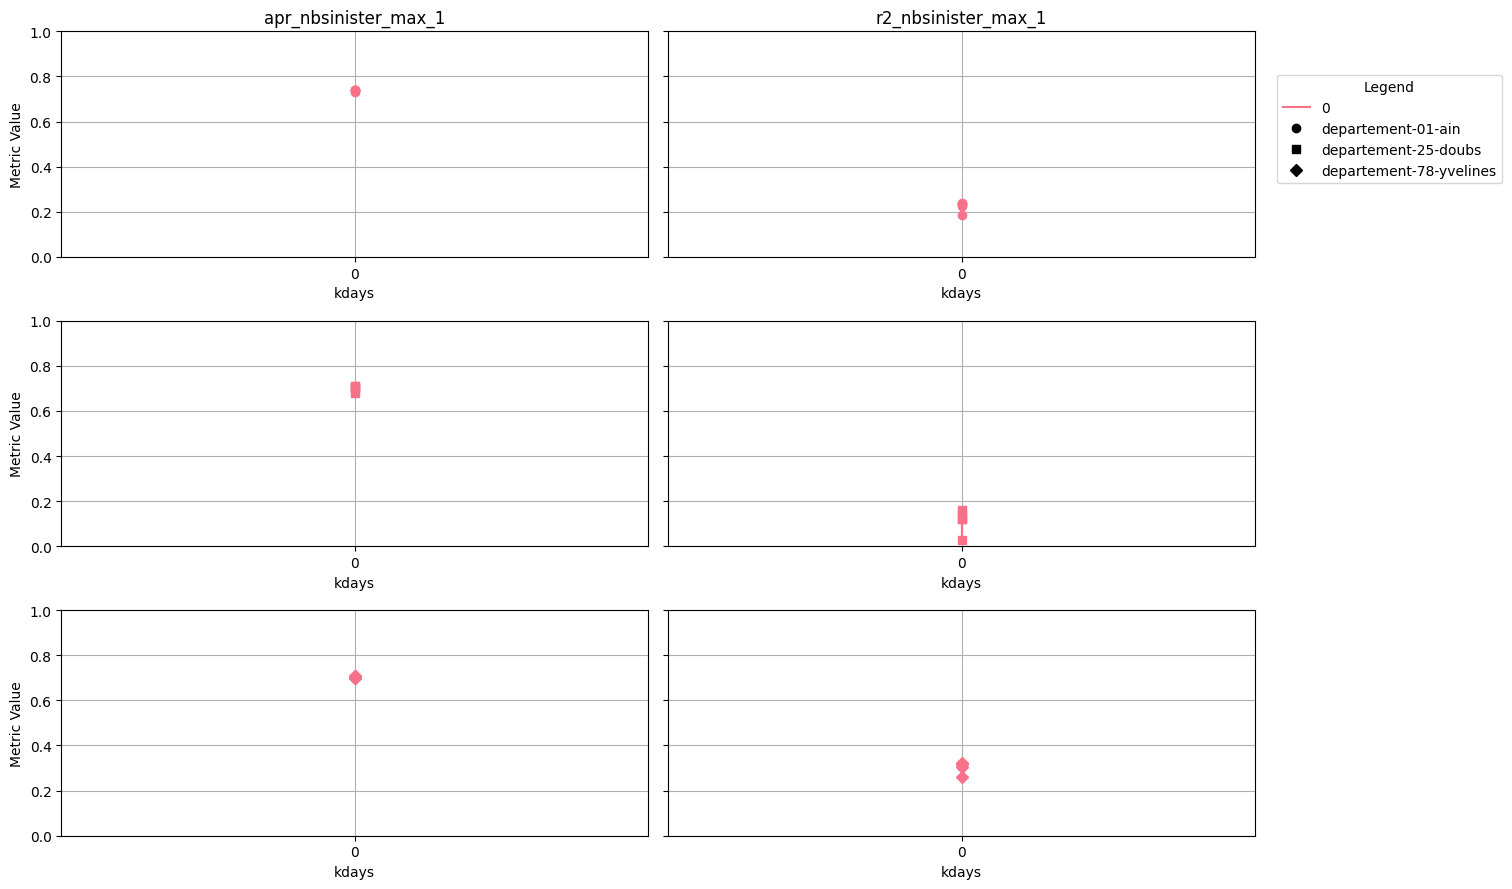

In [9]:
metrics =  ['apr_nbsinister_max_1', 'r2_nbsinister_max_1']

compare_models2(df, df.Department.unique(), dept_markers, metrics, 'departement', 'kdays', Path('./'), '1')

In [10]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.express as px  # Utilisé pour générer une palette de couleurs

def compare_models_2d(df, depts, dept_markers, metrics, col_to_analyse_1, col_to_analyse_2, col_link):
    """
    Compare models in 2D with the third dimension being the metric plotted as an axis.
    Points with the same value in `col_link` are connected in increasing order with a different color.
    Each plot is interactive and can be moved independently using Plotly.

    :param df: DataFrame containing the data.
    :param depts: List of departments to analyze.
    :param dept_markers: Dictionary mapping departments to plot markers.
    :param metrics: List of metrics to plot as Z-axis.
    :param col_to_analyse_1: First column to analyze on X-axis.
    :param col_to_analyse_2: Second column to analyze on Y-axis.
    :param col_link: Column used to connect points in the same group.
    """
    # Generate a unique color for each unique value in col_link
    unique_links = df[col_link].unique()
    colors = px.colors.qualitative.Plotly[:len(unique_links)]

    # Map each unique link to a specific color
    color_map = {link: colors[i % len(colors)] for i, link in enumerate(unique_links)}

    for dept in depts:
        df_filtered = df[df['Department'] == dept]

        for metric in metrics:
            fig = go.Figure()

            # Add a trace for each unique value in col_link (to connect points belonging to the same group)
            for link_value in df_filtered[col_link].unique():
                subset = df_filtered[df_filtered[col_link] == link_value]

                # Sort the subset by col_to_analyse_1 and col_to_analyse_2 for ordered plotting
                subset = subset.sort_values(by=[col_to_analyse_1, col_to_analyse_2])
                if len(subset) < 2:
                    continue  # Skip if less than 2 points to connect

                fig.add_trace(go.Scatter3d(
                    x=subset[col_to_analyse_1],
                    y=subset[col_to_analyse_2],
                    z=subset[metric],  # Plot original metric values on the Z-axis
                    mode='lines+markers',
                    marker=dict(
                        size=8,
                        color=color_map[link_value],  # Assign a unique color for each line
                    ),
                    line=dict(
                        color=color_map[link_value],  # Use the same color for the line
                        width=3  # Line width
                    ),
                    name=f"{dept} - {metric} - {link_value}",
                ))

            # Update the layout to add titles and axis labels for 3D scatter plot
            fig.update_layout(
                scene=dict(
                    xaxis_title=col_to_analyse_1,
                    yaxis_title=col_to_analyse_2,
                    zaxis_title='Metric',
                    xaxis=dict(type='linear'),  # Force linear scale for increasing order
                    yaxis=dict(type='linear'),
                    zaxis=dict(type='linear')
                ),
                title=f"3D Comparison for {dept} - {metric}",
                height=700,
                width=1000
            )

            # Show the plot for this specific department and metric
            fig.show()


In [11]:
df.loc[df[df['Scale'] == 'departement'].index, 'Scale'] = 10

In [12]:
for col in df.columns:
    print(col)

Unnamed: 0
Run
apr_nbsinister_max_1
r2_nbsinister_max_1
KS_nbsinister_max_1
ks_1.0_nbsinister_max_1
ks_2.0_nbsinister_max_1
ks_3.0_nbsinister_max_1
ks_4.0_nbsinister_max_1
mae_raw_nbsinister_max_1
mse_raw_nbsinister_max_1
mae_fire_raw_nbsinister_max_1
mse_fire_raw_nbsinister_max_1
common_area_raw_nbsinister_max_1
union_area_raw_nbsinister_max_1
under_predicted_area_raw_nbsinister_max_1
over_predicted_area_raw_nbsinister_max_1
iou_raw_nbsinister_max_1
iou_under_prediction_raw_nbsinister_max_1
iou_over_prediction_raw_nbsinister_max_1
wildfire_predicted_raw_nbsinister_max_1
wildfire_supposed_raw_nbsinister_max_1
wildfire_over_predicted_raw_nbsinister_max_1
wildfire_under_predicted_raw_nbsinister_max_1
over_bad_prediction_raw_nbsinister_max_1
under_bad_prediction_raw_nbsinister_max_1
bad_prediction_raw_nbsinister_max_1
common_area_day_raw_nbsinister_max_1
union_area_day_raw_nbsinister_max_1
under_predicted_area_day_raw_nbsinister_max_1
over_predicted_area_day_raw_nbsinister_max_1
iou_day_r

In [13]:
df.kmeans_thresh.unique()

array(['0.5', '0.8', '0.1', '0.30000000000000004', '0.7000000000000001',
       '0', '0.2'], dtype=object)

In [15]:
compare_models_2d(df, df.Department.unique(), dept_markers, ['bad_prediction_modified_nbsinister_max_1'], 'Scale', 'kmeans_thresh', 'Scale')

###